In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from BCBio.GFF import GFFExaminer
import pprint
from Bio import SeqIO
from BCBio import GFF
from IPython.display import Image

# Задание 1.​ Определение дифференциальной экспрессии

<b>В папке курса на Google Drive хранится файл 0​ 1. RiboSeq_RNASeq_HCC_counts.tsv, в котором содержится матрица каунтов результатов Ribo-Seq и RNA-Seq экспериментов больных гепатоцеллюлярной карциномой. Матрица каунтов была получена стандартным воркфлоу STAR. На каждого пациента приходится 4 столбца в таблице (RNA-Seq нормы и опухоли, Ribo-Seq нормы и опухоли), записанные в виде ​sample_number-tissue_type-experiment.</b>

In [6]:
df = pd.read_csv('HSE_RiboSeq_HT/01. RiboSeq_RNASeq_HCC_counts.tsv', sep='\t', index_col='geneSymbol')
del df['geneID']

In [37]:
df.head()

,LC001-normal-RPF,LC001-tumor-RPF,LC001-normal-RNA,LC001-tumor-RNA,LC033-normal-RPF,LC033-tumor-RPF,LC033-normal-RNA,LC033-tumor-RNA,LC034-normal-RPF,LC034-tumor-RPF,...,LC507-normal-RNA,LC507-tumor-RNA,LC508-normal-RPF,LC508-tumor-RPF,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RPF,LC509-tumor-RPF,LC509-normal-RNA,LC509-tumor-RNA
geneSymbol,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0,0,402,873,0,0,301,1627,0,0,...,218,457,0,0,200,889,0,0,161,857.0
TNMD,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,NaN
DPM1,168,239,88,187,114,439,66,201,325,117,...,92,170,109,357,60,244,141,173,56,83.0
SCYL3,65,121,60,106,36,163,70,156,130,76,...,127,176,67,176,55,261,64,100,68,176.0
C1orf112,8,43,18,70,16,76,4,63,44,14,...,124,437,7,167,34,201,6,61,9,58.0


In [4]:
df.shape

(18945, 40)

<b>Для каждого гена найдите коэффициент корреляции числа каунтов между экспериментами RNA-Seq и Ribo-Seq. Какую корреляцию вы выберете — Пирсона или Спирмена? Обратите внимание, что перед вами не нормированные каунты. </b>

Отнормируем каунты, просто разделив их на размер библиотеки и умножив на 10^6. Получим CPM.

Следует выбрать корреяцию Спирмена, потому что мы хотим отследить просто схожесть RNA-Seq и Ribo-Seq экспериментов, а не изучать линейность их связи.

In [5]:
s = df.sum(axis=0)

In [6]:
s[:4]

LC001-normal-RPF    5613864.0
LC001-tumor-RPF     4257175.0
LC001-normal-RNA    4437075.0
LC001-tumor-RNA     4853555.0
dtype: float64

In [19]:
rna_col = [x for x in list(df.columns) if 'RNA' in x]
rpf_col = [x for x in list(df.columns) if 'RPF' in x]

In [13]:
len(rna_col), len(rpf_col)

(20, 20)

In [9]:
df_norm = df/s*10**6

In [10]:
df_norm.head()

,LC001-normal-RPF,LC001-tumor-RPF,LC001-normal-RNA,LC001-tumor-RNA,LC033-normal-RPF,LC033-tumor-RPF,LC033-normal-RNA,LC033-tumor-RNA,LC034-normal-RPF,LC034-tumor-RPF,...,LC507-normal-RNA,LC507-tumor-RNA,LC508-normal-RPF,LC508-tumor-RPF,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RPF,LC509-tumor-RPF,LC509-normal-RNA,LC509-tumor-RNA
geneSymbol,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.000000,0.000000,90.600227,179.868158,0.000000,0.000000,80.378639,290.386891,0.000000,0.000000,...,45.653370,88.660635,0.000000,0.000000,46.778833,145.009945,0.000000,0.000000,48.841219,150.341329
TNMD,0.000000,0.000000,0.000000,0.206035,0.000000,0.000000,0.000000,0.178480,0.000000,0.000000,...,0.000000,0.000000,0.205046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
DPM1,29.925912,56.140516,19.832885,38.528460,23.885265,49.163025,17.624552,35.874471,26.133408,34.374579,...,19.266560,32.980980,22.349966,51.647819,14.033650,39.800255,27.386761,32.582707,16.988250,14.560479
SCYL3,11.578478,28.422604,13.522422,21.839662,7.542715,18.254153,18.692707,27.842873,10.453363,22.328787,...,26.596229,34.145015,13.738052,25.462230,12.864179,42.573223,12.430870,18.833935,20.628590,30.875232
C1orf112,1.425043,10.100595,4.056727,14.422418,3.352318,8.511139,1.068155,11.244237,3.538061,4.113198,...,25.967972,84.780519,1.435319,24.160184,7.952402,32.786276,1.165394,11.488700,2.730254,10.174792


In [11]:
corr = []
for i in range(len(df_norm)):
    corr.append(stats.spearmanr(df_norm.iloc[i][rna_col], df_norm.iloc[i][rpf_col])[0])

/Users/kudpolser/miniconda3/envs/diffexpr/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<b>Постройте гистограмму распределения этих коэффициентов корреляции. Для каких генов корреляция самая высокая, а для каких — самая низкая? Как вы можете это объяснить?</b>

In [12]:
len(corr)

18945

In [13]:
corr_clean = np.array([x for x in corr if str(x) != 'nan'])

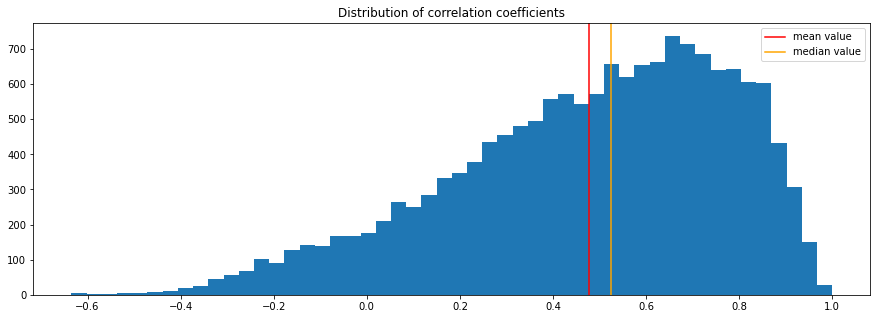

In [17]:
plt.figure(figsize=(15,5))
plt.hist(corr, bins=50)
plt.axvline(corr_clean.mean(), color='red', label='mean value')
plt.axvline(np.median(corr_clean), color='orange', label='median value')
plt.title("Distribution of correlation coefficients")
plt.legend()
plt.show()

Средняя корреляция между Ribo-Seq и RNA-Seq экспериментами около 0.47. Видно, что распределение смещено в сторону положительных значений и медиана находится правее. В общем, результаты экспериментов чаще имеют положительную корреляцию.

In [37]:
for i in range(len(corr)):
    if corr[i] > 0.98:
        print('{:10s} {}'.format(df.iloc[i].name, round(corr[i], 3)))

PCK1       0.983
SLC27A2    0.98
TMEM45B    0.986
CYP7A1     0.986
FAM46D     1.0
APOF       0.982
CYP4A11    0.985
RFPL4B     1.0


In [42]:
for i in range(len(corr)):
    if abs(corr[i]) < 0.001:
        print('{:10s} {}'.format(df.iloc[i].name, round(corr[i], 3)))

CDH7       -0.001
MYH3       0.0
B3GAT2     -0.001
PGF        -0.001
ZC3H4      0.0
C5AR2      0.0
RANBP10    0.0
ZSCAN23    0.0
TRPV1      0.001
GPR179     0.0


Поищем данные гены в базе ncbi. Высокая корреляция характерна для генов активно работающих в клетке в любое время. Они участвуют в глюкозном обмене, обработке жирных кислот и пр. Низкая корреляция у генов, которые работают в определенный момент, а значит рибосомы сидят на них реже. Напрмер, гены, кодирующие белки для образования микротрубочек.

Думаю, что это связано с процессами регуляции трансляции. Для части белков транскрипты производятся, но рибосомы не превращают их в белки, потому что клетке это сейчас не нужно.

<b>Найдите дифференциально экспрессированные гены по RNA-Seq между нормой и опухолью. Для этого можете использовать DESeq2 или edgeR (для DESeq есть обёртка на Python). Постройте volcano plot. То же самое сделайте и для Ribo-Seq эксперимента. Совпадают ли результаты дифференциальной экспрессии? Какие гены оказались значимо различны по экспрессии в одном случае, а какие — в другом? Выводы подкрепите графиками.</b>

In [1]:
from diffexpr.py_deseq import py_DESeq2
from matplotlib.lines import Line2D

In [5]:
df = df.fillna(0)

In [97]:
samples = list(set([x[:-4] for x in df.columns]))
tissue = [x[6:] for x in samples]
samples = [x[:5] for x in samples]
design = pd.DataFrame({"tissue": tissue})
design.head()

,tissue
0,normal
1,normal
2,tumor
3,tumor
4,tumor


In [98]:
len(samples), len(tissue)

(20, 20)

In [99]:
dds = df.assign(geneID=df.index)
dds = py_DESeq2(count_matrix = dds[rpf_col + ['geneID']],
                design_matrix = design,
                design_formula = '~ tissue',
                gene_column = 'geneID')
dds.run_deseq()
dds.get_deseq_result(contrast = ['tissue','normal','tumor'])
rpfres = dds.deseq_result







-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)



INFO:DESeq2:Using contrast: ['tissue', 'normal', 'tumor']


In [100]:
dds = df.assign(geneID=df.index)
dds = py_DESeq2(count_matrix = dds[rna_col + ['geneID']],
                design_matrix = design,
                design_formula = '~ tissue',
                gene_column = 'geneID')
dds.run_deseq()
dds.get_deseq_result(contrast = ['tissue','normal','tumor'])
rnares = dds.deseq_result








-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)



INFO:DESeq2:Using contrast: ['tissue', 'normal', 'tumor']


/Users/kudpolser/miniconda3/envs/diffexpr/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


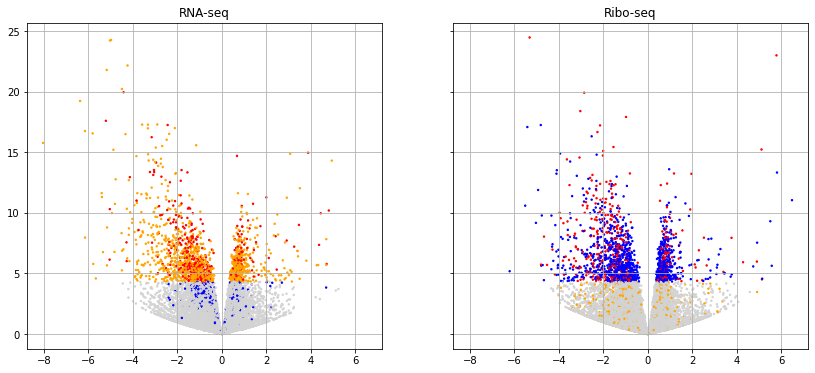

In [101]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

colors = np.array(['lightgrey']*len(rnares))
colors[rnares["pvalue"] < 0.05] = 'orange' #значимые по rnaseq
colors[rpfres["pvalue"] < 0.05] = 'blue' #значимые по riboseq
colors[(rnares["pvalue"] < 0.05) & (rpfres["pvalue"] < 0.05)] = 'red' #значимые везде

ax0.grid()
ax1.grid()

ax0.scatter(rnares['log2FoldChange'], -np.log2(rnares.pvalue), color=colors, s=2)
ax1.scatter(rpfres['log2FoldChange'], -np.log2(rpfres.pvalue), color=colors, s=2)

ax0.set_title("RNA-seq")
ax1.set_title("Ribo-seq")

plt.show()

In [102]:
both_mask = (rnares["pvalue"] < 0.05) & (rpfres["pvalue"] < 0.05)
not_both = np.logical_not(both_mask)

In [107]:
#топ 10 генов значимых только по rna-seq
rnares[(rnares["pvalue"] < 0.05)&not_both].sort_values('pvalue')[['geneID', 'pvalue']][:10]

,geneID,pvalue
3112,PDE4C,4.884766e-08
13856,ERBB4,5.059007e-08
4149,WWC1,2.108022e-07
15304,KANK3,2.719745e-07
4592,KCNQ4,8.072470e-07
8114,SYPL2,1.611683e-06
2258,NCF4,6.162103e-06
12241,HTRA4,6.214010e-06
16514,TOX,6.231623e-06
8175,RGS16,7.585423e-06


In [106]:
#топ 10 генов значимых только по ribo-seq
rpfres[(rpfres["pvalue"] < 0.05)&not_both].sort_values('pvalue')[['geneID', 'pvalue']][:10]

,geneID,pvalue
3281,GLI3,0.000006
4399,IL18RAP,0.000007
11913,VWCE,0.000012
12258,CLIC3,0.000033
10328,COX7A1,0.000035
17715,IGHV4-31,0.000052
588,DCUN1D1,0.000080
17085,IGLV2-14,0.000085
13535,RIMS2,0.000097
14777,PKP3,0.000103


In [105]:
#топ 10 генов значимых в обоих экспериментах
rpfres[both_mask].sort_values('pvalue')[['geneID', 'pvalue']][:10]

,geneID,pvalue
18733,CCL3L3,4.237294e-08
1508,AFP,1.181055e-07
18732,CCL4L2,1.001237e-06
11582,RRAD,2.873738e-06
2401,ZMYND8,4.018869e-06
6713,SPIRE1,6.514515e-06
4790,CCND2,9.533802e-06
14032,MYADM,2.242347e-05
15018,DLK1,2.584310e-05
4756,CTGF,2.802653e-05


In [95]:
rnares[both_mask].sort_values('pvalue')[['geneID', 'pvalue']][:10]

,geneID,pvalue
12978,CCDC96,9.763075e-07
15519,OTOG,4.997451e-06
18732,CCL4L2,6.369438e-06
623,ARHGAP6,1.280362e-05
15018,DLK1,3.112360e-05
12062,NDUFS5,3.730014e-05
7558,ANXA3,5.465017e-05
18733,CCL3L3,8.368630e-05
10760,NUAK2,8.411155e-05
2056,SYDE2,9.355176e-05


Видно, что результаты экспериментов слабо пересекаются. Если в одном эксперименте ген значим, то в другом с высокой вероятностью оказывается не значим. 

Но здорово то, что на пересечении много генов принадлежащих пасвею cellular response to tumor necrosis factor (проверила просто несколько генов по базе). В общем, основной результат в том, что стоит смотреть на пересечение результатов. 

Однако важно отметить также, что большинство генов значимых везде, находятся в начале списка значимости по ribo-seq (так как оставшийся топ уже обладает большими p-value), что говорит о том, что ribo-seq все же лучше отражает ситуацию в клетке.

# Задание 2.​ Анализ wig-файла

<b>В папке курса на Google Drive хранятся два файла с .wig-трэками Ribo-Seq эксперимента кишечной палочки: 02. RiboSeq_EColi_track_f.wig и 02. RiboSeq_EColi_track_r.wig для прямой и обратной цепочек соответственно. Трэки эти были получены следующим образом: сначала прочтения прошли QC, адаптеры были удалены, а получившиеся “чистые” риды были откартированы на геном кишечной палочки. Затем каждой геномной позиции были присвоены значения, соответствующие числу 3’-концов прочтений, был определён оффсет для определения P-сайта, после чего скорректированные на этот оффсет значения и были записаны в wig-файл. Референсный геном, использовавшийся в ходе обработки прочтений, — U00096.3. Для выполнения заданий вам потребуется его аннотация (её вы можете найти в GenBank).</b>

In [11]:
df_f = pd.read_csv('HSE_RiboSeq_HT/02. RiboSeq_EColi_track_f.wig', sep='\t')
df_r = pd.read_csv('HSE_RiboSeq_HT/02. RiboSeq_EColi_track_r.wig', sep='\t')

In [13]:
df_f.head()

,variableStep chrom=U00096.3
40,1
77,2
85,1
139,1
147,1


In [24]:
in_seq_file = "sequence2.fasta"
in_seq_handle = open(in_seq_file)
seq_dict = SeqIO.to_dict(SeqIO.parse(in_seq_handle, "fasta"))
in_seq_handle.close()

In [46]:
in_handle = open('sequence.gff3')
for rec in GFF.parse(in_handle, base_dict=seq_dict):
    print(rec)
in_handle.close()

ID: U00096.3
Name: U00096.3
Description: U00096.3 Escherichia coli str. K-12 substr. MG1655, complete genome
Number of features: 4728
/sequence-region=[('U00096.3', 0, 4641652)]
/species=['https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=511145']
Seq('AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAG...TTC', SingleLetterAlphabet())


<b>Присутствует ли в покрытии генома неравномерность? Рассмотрите неравномерность покрытия на примере любого выбранного вами гена. Что вы можете сказать про эту неравномерность? Присутствует ли там периодичность в три нуклеотида? А если взять среднее по большому количеству генов (взяв за точку отсчёта старт-кодон)? Выводы проиллюстрируйте графиками.</b>

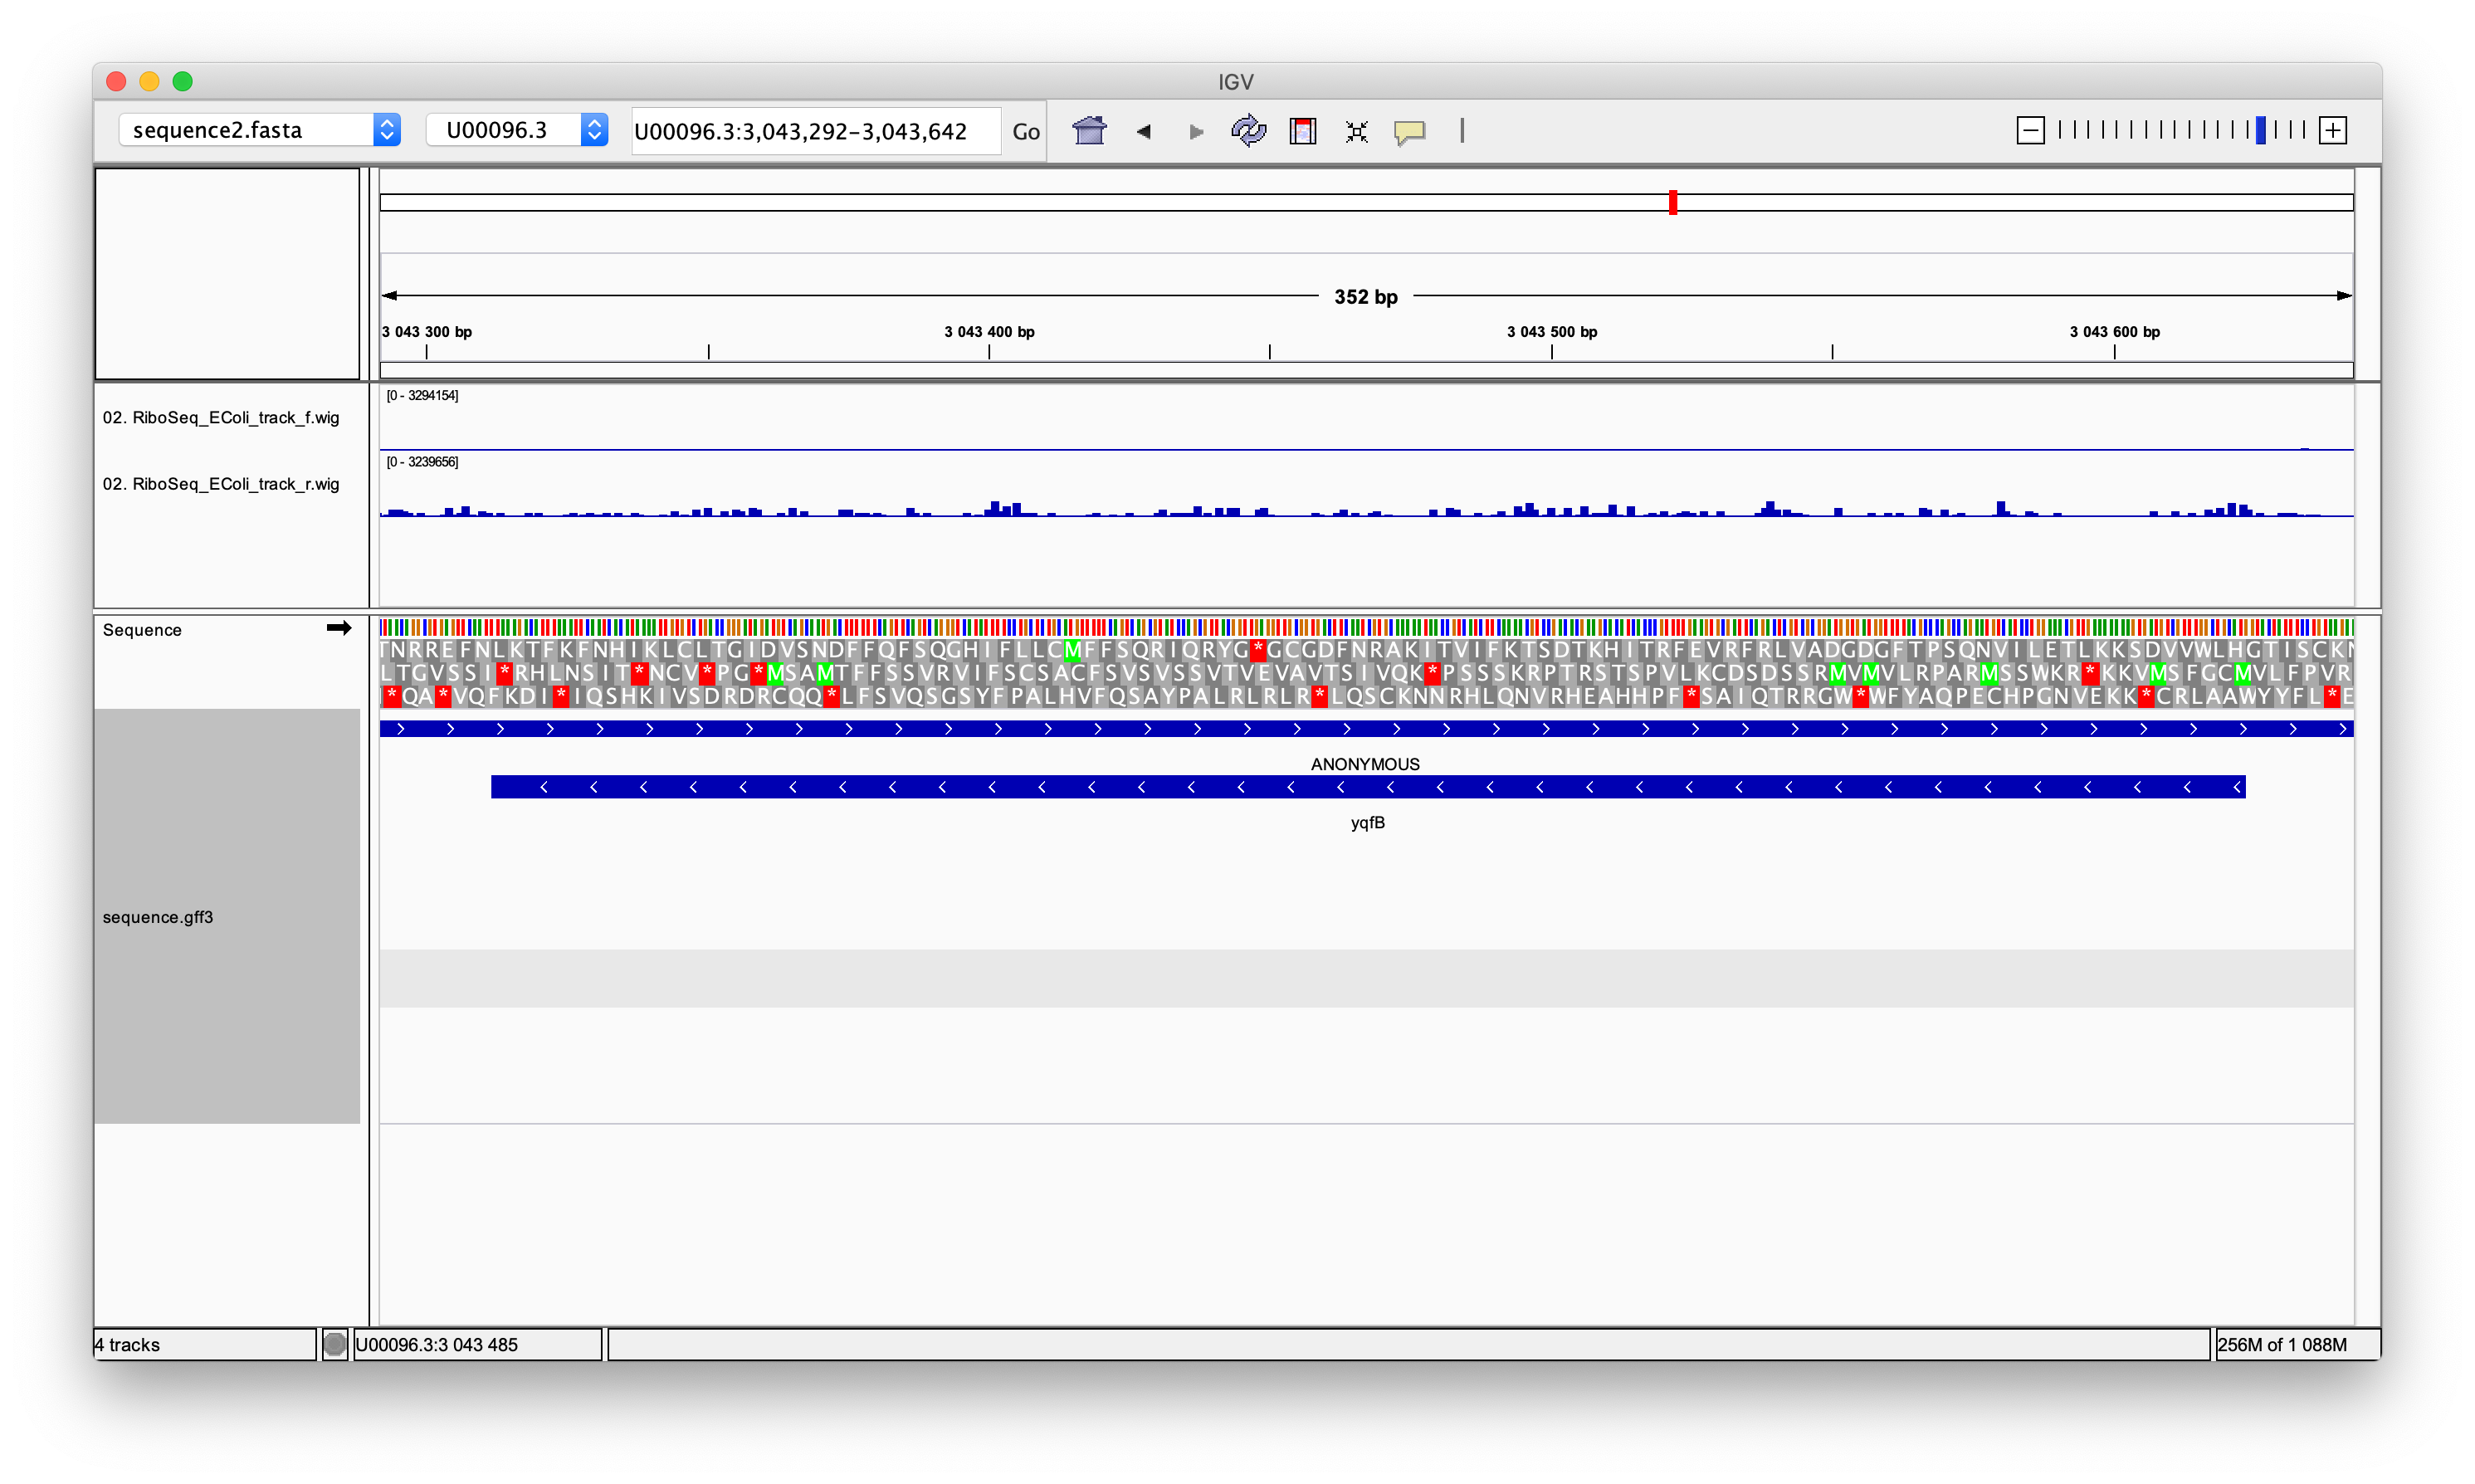

In [125]:
#выбрем ген iqfB
Image(filename='iqfB.png') 

In [135]:
gene_id = 3124
print(rec.features[gene_id].id)
print(rec.features[gene_id].qualifiers['Name'])
print('start: ', rec.features[gene_id].location.start, '\nend: ', rec.features[gene_id].location.end)

gene-b2900
['yqfB']
start:  3043311 
end:  3043623


In [138]:
wig_one_gene = {}
for i in range(len(df_r)):
    if df_r.iloc[i].name >= rec.features[gene_id].location.start and \
    df_r.iloc[i].name <= rec.features[gene_id].location.end:
        wig_one_gene[df_r.iloc[i].name] = int(df_r.iloc[i])

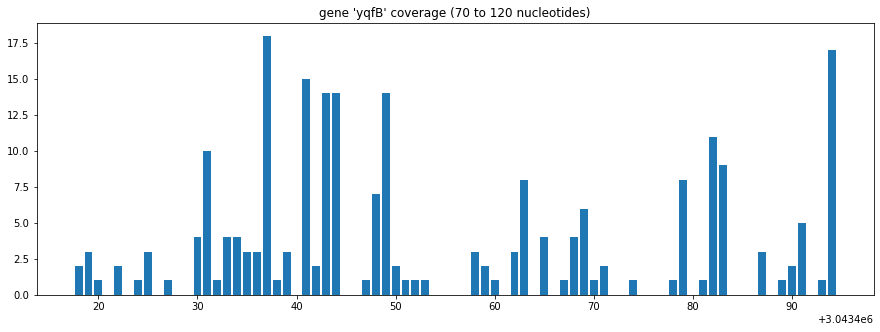

In [241]:
plt.figure(figsize=(15,5))
plt.bar(list(wig_one_gene.keys())[69:120], list(wig_one_gene.values())[69:120])
plt.title("gene 'yqfB' coverage (70 to 120 nucleotides)")
#plt.yscale('log')
plt.show()

Покрытие неравномерное, но периодичность в три нуклеотида заметить сложно. Возможно это связано с низким покрытием некторых участков, видно, что есть большие дыры. 

Попробуем усреднить покрытие по нескольким генам. Возьмем первые сто генов и вытянем их нуклеотидные последовательности. Отрежем их по старт кодону и сохраним новые координаты. Также сохраним число генов, пришедшихся на координату, чтобы правильно посчиать среднее.

In [198]:
seq = {}
coord = {}
max_l = 0
for i in range(1,101):
    seq[i] = rec.seq[rec.features[i].location.start:rec.features[i].location.end]
    coord[i] = [rec.features[i].location.start + seq[i].find('ATG'), int(rec.features[i].location.end)]
    if max_l < int(rec.features[i].location.end) - rec.features[i].location.start + seq[i].find('ATG'):
        max_l = int(rec.features[i].location.end) - rec.features[i].location.start + seq[i].find('ATG')

In [199]:
max_l

3222

In [233]:
cov = np.zeros(max_l)
n_gen = np.zeros(max_l)
for i in range(1, 101):
    for j in range(coord[i][0], coord[i][1]):
        try:
            cov[j - coord[i][0]] += int(df_r.iloc[j])
            n_gen[j - coord[i][0]] += 1
        except:
            continue

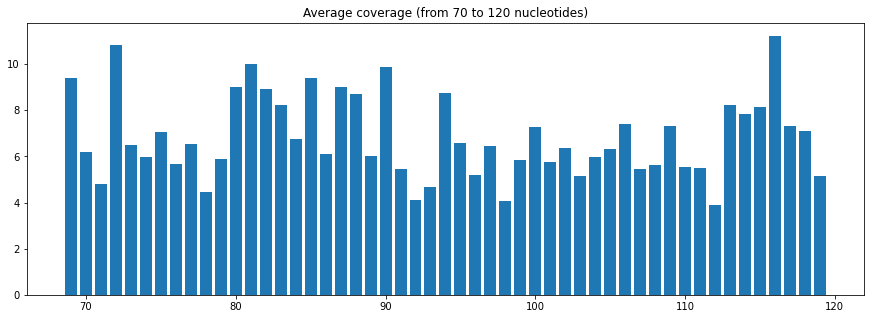

In [240]:
plt.figure(figsize=(15,5))
plt.bar(range(max_l)[69:120], list(cov/n_gen)[69:120])
plt.title("Average coverage (from 70 to 120 nucleotides)")
plt.show()

Покрытие стало равномерным, но периодичность в три нуклеотида я по-прежнему не вижу. 

<b>Рассчитайте значения RPKM и TPM для каждого гена. В чём разница между RPKM и TPM? Для чего используется каждая метрика?

$RPKM = \frac{r_g}{l_g*\sum{r_g}}*10^9$ 

$TPM = \frac{r_g/l_g}{\sum{r_g/l_g}}*10^6$,

где $r_g$ — число ридов в гене, $l_g$ — длина гена

Обе метрики используются для вычисления числа ридов, картирующихся на ген, то есть для вычисления их экспресии. RPKM - это количество ридов, попавших на ген, сокорректированная на длину гена и размер библиотеки. TPM - это отношение числа ридов на длину гена, скорректированная на суммарное отношение по библиотке. По сути метрики очень похожи, но в случае RPKM мы считаем число ридов, пришедшихся на данный ген, из общего числа ридов, а в случае с TPM мы уже сравниваем доли.

In [288]:
n_reads = []
l_gene = []
for i in range(1, len(rec.features)):
    
    mask = (df_r.index >= rec.features[i].location.start) & (df_r.index <= rec.features[i].location.end)
    n_reads.append(int(df_r[mask].sum()))
    
    mask = (df_f.index >= rec.features[i].location.start) & (df_f.index <= rec.features[i].location.end)
    n_reads[i-1] += int(df_f[mask].sum())
    
    l_gene.append(rec.features[i].location.end - rec.features[i].location.start)

In [289]:
n_reads = np.array(n_reads)
l_gene = np.array(l_gene)

sum_r = sum(n_reads)
sum_rl = sum(n_reads/l_gene)

In [292]:
rpkm = []
tpm = []

for i in range(len(rec.features)-1):
    rpkm.append(n_reads[i]*pow(10,9)/(l_gene[i]*sum_r))
    tpm.append(n_reads[i]/l_gene[i]*pow(10,6)/sum_rl)

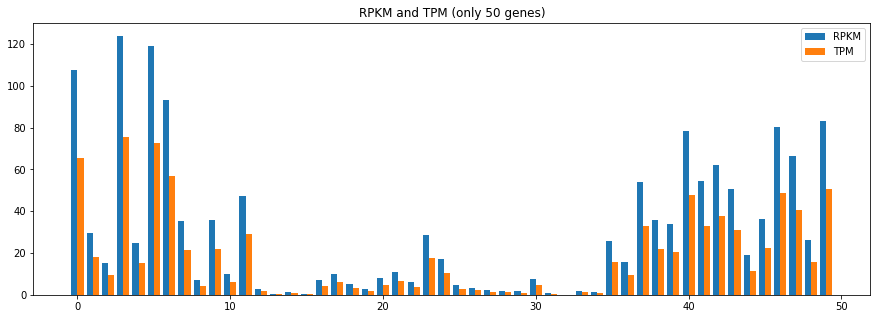

In [334]:
plt.figure(figsize=(15,5))
x = np.array(range(len(rpkm))[:50])

plt.bar(x-0.2, rpkm[50:100], width=0.4, align='center', label='RPKM')
plt.bar(x+0.2, tpm[50:100], width=0.4, align='center', label='TPM')
#plt.plot(x, rpkm[50:100], label='RPKM')
#plt.plot(x, tpm[50:100], label='TPM')
plt.legend()
plt.title("RPKM and TPM (only 50 genes)")
plt.show()

<b>Проанализируйте значения RPKM для генов из оперона ATP. Укажите геномные координаты оперона, а также то, какие гены в него входят. Есть ли разница между RPKM у различных генов, присутствующих в опероне? Как вы можете объяснить эту разницу с биологической точки зрения? Как вы думаете, можно ли оценить эту разницу при помощи классического RNA-Seq?</b>

Попробуем найти оперон просто по названиям генов. Они скорее всего будут включать в себя подсроку 'atp'. Выведем порядковые номера этих генов, а также их координаты оперона.

Выведем значения RPKM для всех генов, входящий в оперон.
Посчитаем координаты оперона.

In [383]:
for i in range(1, len(rec.features)):
    try:
        if rec.features[i].qualifiers['Name'][0].find('atp') >= 0:
            print('{}, {}\nstart: {}\nend:   {}\n'.format(i, rec.features[i].qualifiers['Name'][0],
                                                          rec.features[i].location.start,
                                                          rec.features[i].location.end))
    except:
        continue

4018, atpC
start: 3915552
end:   3915972

4019, atpD
start: 3915992
end:   3917375

4020, atpG
start: 3917401
end:   3918265

4021, atpA
start: 3918315
end:   3919857

4022, atpH
start: 3919869
end:   3920403

4023, atpF
start: 3920417
end:   3920888

4024, atpE
start: 3920949
end:   3921189

4025, atpB
start: 3921235
end:   3922051

4026, atpI
start: 3922059
end:   3922440



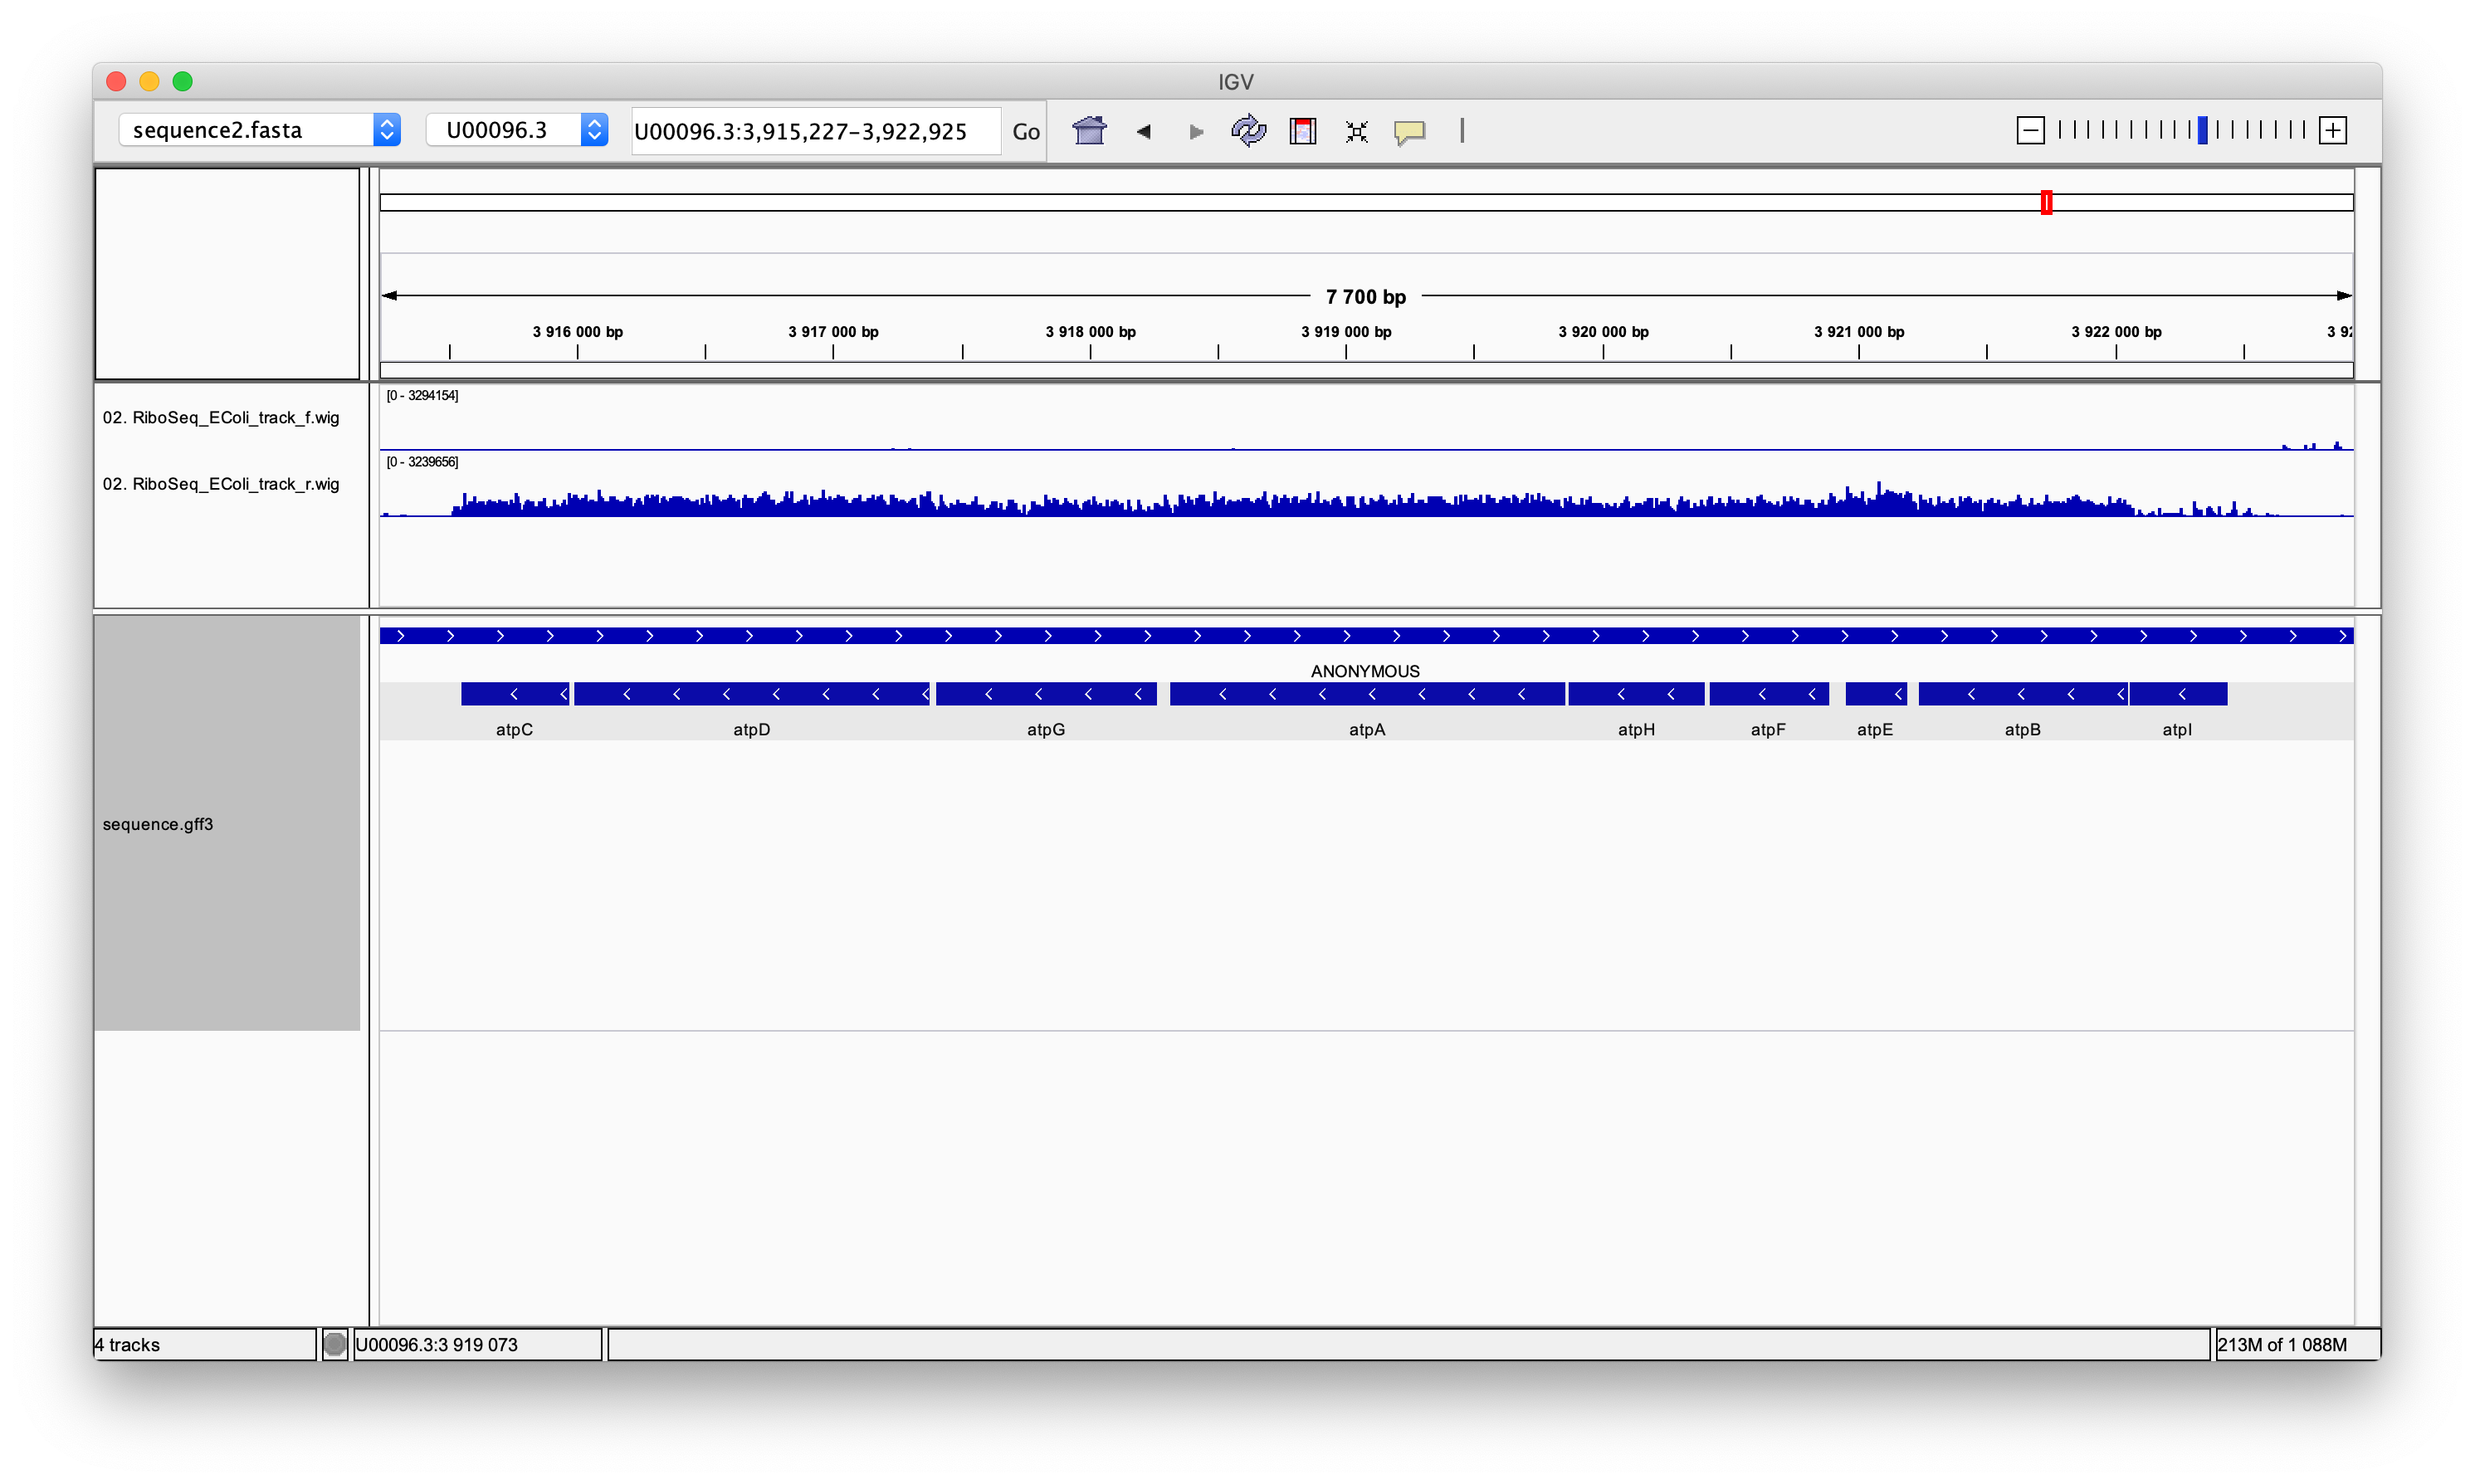

In [376]:
#так выгляит оперон в браузере, его координаты 3915552:3922440
Image(filename='atp.png') 

In [393]:
for i in range(4017,4026):
    print('{}  {:4d}'.format(rec.features[i+1].qualifiers['Name'][0], int(rpkm[i])))

atpC   462
atpD  1021
atpG   244
atpA   795
atpH   299
atpF   449
atpE  4990
atpB   470
atpI    22


Явно заметна повышенная экспрессия субъединицы E. D и A также имеют больший RPKM, может это связано с их большим размером, и корректировка на длину гена должна быть жестче. У меня нет хороших догадок почему рибосомы чаще сидят на E субъединице, чем на остальных. Возмжно она самая маленькая и быстрее деградирует, поэтому требуется производить ее больше, так как часть не успевает попасть в итоговый белок, а разрушается раньше. Или она чаще участвует в построении белка. Скорее нужно 5 едениц субъединицы Е и по одной еденице всех остальных.

На данных RNA-seq экспериментов разница была бы незаметна, так как транскрипт производится одновременно для всего оперона, поэтому RPKM был бы похож для всех субъединиц. 